In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial
from IPython.display import clear_output
from tabulate import tabulate

## Cocycle Example 1.1 (Noise mis-specification):

$X \sim N(0,1)$

$Y = X+U : U \sim Lap(0,1/2)$

$Z =\exp(Y)+V : V \sim N(0,1)$

In [2]:
def f(x):
    return x

def fhat(x,beta):
    return x @ beta

def g(x):
    return np.exp(x)

def ghat(x,beta):
    return np.exp(x @ beta)

def affine(x,a,b):
    return a*x + b

def cocycle(intervention,x,function):
    return function(intervention(x)) - function(x)

def mgf_laplace(mean,scale,t):
    return np.exp(t*mean)/(1-t**2*scale**2)

def mgf_normal(mean,sd,t):
    return np.exp(t*mean+0.5*t**2*sd**2)

def betahat(X,y):
    return np.linalg.solve(X.T @ X, X.T @ y)

def sigmahat(X,y,beta):
    error = y - X @ beta
    return np.sqrt(np.mean(error**2))

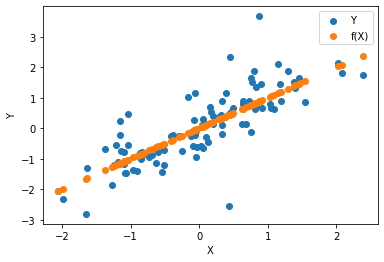

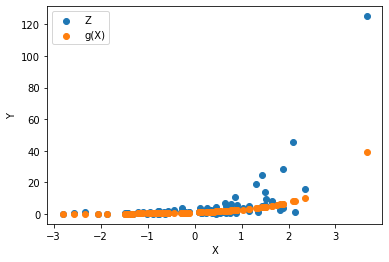

0.4660675417339785 5.945861501422851


In [3]:
# generating data:
mean_l,scale_l = 0,1/2
mean_n,sd_n = 0,1

laplace = partial(np.random.laplace,mean_l,scale_l)
normal = np.random.standard_normal
ndata = 10**2
X = normal(ndata)
Y = f(X)+laplace(ndata)
Z = g(Y)*np.exp(normal(ndata))
plt.scatter(X,Y, label = "Y")
plt.scatter(X,f(X), label = "f(X)")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()
plt.scatter(Y,Z, label = "Z")
plt.scatter(Y,g(Y), label = "g(X)")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()

# Maximum likelihood variance estimates
var_y = np.mean((Y-f(X))**2)
var_z = np.mean((Z/g(Y))**2)
print(var_y, var_z)

### With parameter estimation

In [4]:
# Dataset size
normal = np.random.normal
laplace = np.random.laplace
ndata = 10**3*2
ntrial = 10**3
ngrid = 100
Y_scale = np.linspace(0.25,0.75,ngrid)
X_hard = np.linspace(0,1,ngrid)
EX_ols=np.zeros((4,ntrial,ngrid,ngrid))
EY_ols=np.zeros((4,ntrial,ngrid,ngrid))
EZ_ols=np.zeros((4,ntrial,ngrid,ngrid))

# Intervention levels # WARNING: TRUE CAUSAL EFFECT ONLY CORRECT FOR HARD(X),SCALE(Y),SHIFT(Z)
run = 0
for j in range(ngrid):
    for k in range(ngrid):
        run+=1
        Shift_x = X_hard[j] 
        Shift_y = 0 # leave
        Shift_z = 0 # CURRENTLY USING 1.1 

        Scale_x = 0 # leave
        Scale_y = Y_scale[k]
        Scale_z = 1 # leave
        t = 1

        for i in range(ntrial):

            # generating data:
            X = normal(mean_n,sd_n,ndata).reshape(ndata,1)
            Y = f(X)+laplace(mean_l,scale_l,ndata).reshape(ndata,1)
            Z = g(Y)+normal(mean_n,sd_n,ndata).reshape(ndata,1)
            
            # Getting parameters
            betahat_y,betahat_z = betahat(X,Y),betahat(np.exp(Y),Z)
            sigmahat_y,sigmahat_z = sigmahat(X,Y,betahat_y),sigmahat(np.exp(Y),Z,betahat_z)
            
            # generating model-based observational data:
            U_x_correct = normal(mean_n,sd_n,ndata).reshape(ndata,1)
            U_y_correct = laplace(0,sigmahat_y/np.sqrt(2),ndata).reshape(ndata,1)
            U_y_mistake = normal(0,sigmahat_y,ndata).reshape(ndata,1)
            U_z_correct = normal(0,sigmahat_z,ndata).reshape(ndata,1)

            X_correct = U_x_correct # true distribution used for X
            Y_correct = fhat(X_correct, betahat_y)+U_y_correct
            Y_mistake = fhat(X_correct, betahat_y)+U_y_mistake
            Z_correct = ghat(Y_correct, betahat_z)+U_z_correct
            Z_mistake = ghat(Y_mistake, betahat_z)+U_z_correct
            
            # Getting total effect with cocycles
            Effect_x = (np.array(Scale_x),np.array(Shift_x))
            Effect_y = (Scale_y,Shift_y+Scale_y*cocycle(partial(affine,a=Effect_x[0],b = Effect_x[1]),X,partial(fhat,beta = betahat_y)))
            Effect_z = (Scale_z,Shift_z+Scale_z*cocycle(partial(affine,a=Effect_y[0],b = Effect_y[1]),Y,partial(ghat,beta = betahat_z)))
            Ex_cocycle,Ey_cocycle,Ez_cocycle = Effect_x[1].mean(),(Effect_y[0]*Effect_y[1]).mean(),Effect_z[1].mean()

            # Getting total effect with samples
            X_int = Scale_x*U_x_correct+Shift_x
            Ex_sample = (X_int - X_correct).mean()
            Y_int = Scale_y*(fhat(X_int,betahat_y)+U_y_mistake)+Shift_y
            Ey_sample = (Y_int-Y_mistake).mean()
            Z_int = Scale_z*(ghat(Y_int, betahat_z)+U_z_correct)+Shift_z
            Ez_sample = (Z_int-Z_mistake).mean()

            # Getting total effect with samples (correct distribution)
            X_int = Scale_x*U_x_correct+Shift_x
            Ex_sample_correct = (X_int - X_correct).mean()
            Y_int = Scale_y*(fhat(X_int,betahat_y)+U_y_correct)+Shift_y
            Ey_sample_correct = (Y_int-Y_correct).mean()
            Z_int = Scale_z*(ghat(Y_int, betahat_z)+U_z_correct)+Shift_z
            Ez_sample_correct = (Z_int-Z_correct).mean()

            # "True" Ex,Ey,Ez
            Ex,Ey,Ez = Shift_x,Shift_x*Scale_y,Shift_z + Scale_z*np.exp(Scale_y*Shift_x)*mgf_laplace(mean_l,scale_l,Scale_y) - mgf_laplace(mean_l,scale_l,1)*mgf_normal(mean_n,sd_n,1)

            EX_ols[:,i,j,k] = (Ex_sample,Ex_sample_correct,Ex_cocycle,Ex)
            EY_ols[:,i,j,k] = (Ey_sample,Ey_sample_correct,Ey_cocycle,Ey)
            EZ_ols[:,i,j,k] = (Ez_sample,Ez_sample_correct,Ez_cocycle,Ez)

        clear_output(wait=True)
        print((run+1)/ngrid**2*100,"% completed")

100.01 % completed


Text(111.25, 0.5, 'Cocycles')

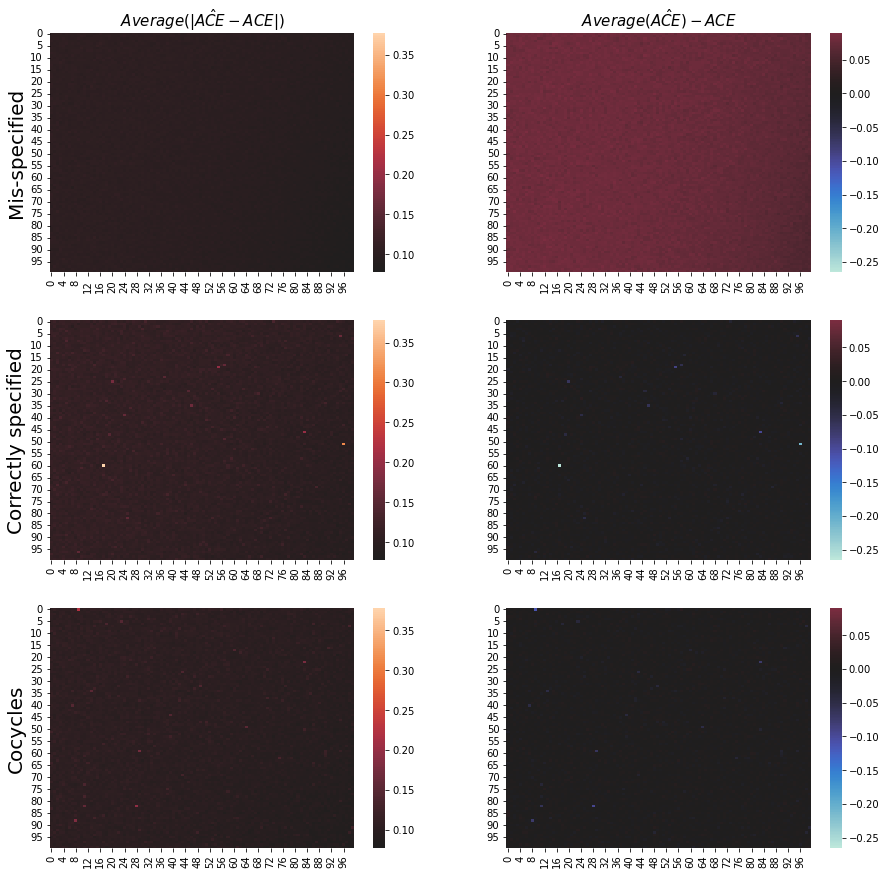

In [5]:
fig,axs = plt.subplots(3,2,figsize = (15,15))
t=0

# Getting max and mins
min_1 = min(np.min(np.abs(EZ_ols[0]- EZ_ols[3]).mean(0)),
            np.min(np.abs(EZ_ols[1]- EZ_ols[3]).mean(0)),
            np.min(np.abs(EZ_ols[2]- EZ_ols[3]).mean(0)))
max_1 = max(np.max(np.abs(EZ_ols[0]- EZ_ols[3]).mean(0)),
            np.max(np.abs(EZ_ols[1]- EZ_ols[3]).mean(0)),
            np.max(np.abs(EZ_ols[2]- EZ_ols[3]).mean(0)))
min_2 = min(np.min(EZ_ols.mean(1)[0]- EZ_ols.mean(1)[3]),
            np.min(EZ_ols.mean(1)[1]- EZ_ols.mean(1)[3]),
            np.min(EZ_ols.mean(1)[2]- EZ_ols.mean(1)[3]))
max_2 = max(np.max(EZ_ols.mean(1)[0]- EZ_ols.mean(1)[3]),
            np.max(EZ_ols.mean(1)[1]- EZ_ols.mean(1)[3]),
            np.max(EZ_ols.mean(1)[2]- EZ_ols.mean(1)[3]))


Row_labels = ["Mis-specified", "Correctly specified", "Cocycles"]
for i in [0,1,2]:
    s = sns.heatmap(np.abs(EZ_ols[i]- EZ_ols[3]).mean(0), center = min_1,vmin = min_1,vmax = max_1, ax = axs[t,0])#, cmap = "RdBu_r")
    sns.heatmap(EZ_ols.mean(1)[i]- EZ_ols.mean(1)[3], center = 0,vmin = min_2,vmax = max_2, ax = axs[t,1])#, cmap = "RdBu_r")
    t+=1
axs[0,0].set_title(r"$Average(|{\hat{ACE}} - ACE|)$", fontsize = 15)
axs[0,0].set_ylabel(Row_labels[0], fontsize = 20)
axs[0,1].set_title(r"$Average({\hat{ACE}}) - ACE$", fontsize = 15)
axs[1,0].set_ylabel(Row_labels[1], fontsize = 20)
axs[2,0].set_ylabel(Row_labels[2], fontsize = 20)
#fig.savefig("heatmap_misspec_example_new",box_inches = "tight")

Text(0.5, 1.0, 'Cocycles')

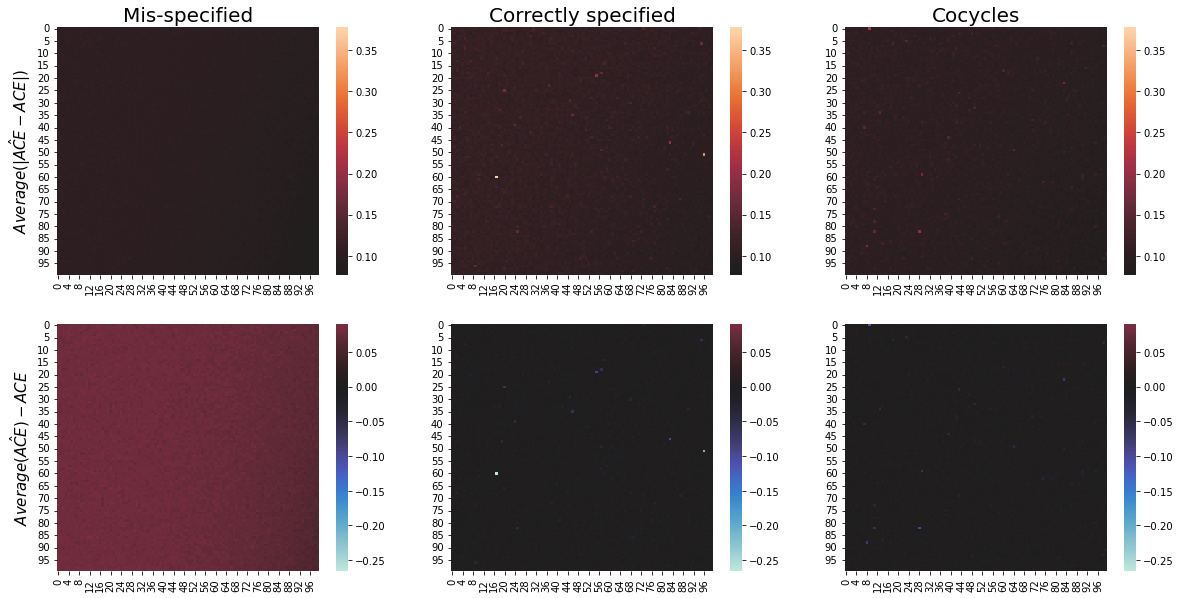

In [6]:
fig,axs = plt.subplots(2,3,figsize = (20,10))
t=0

# Getting max and mins
min_1 = min(np.min(np.abs(EZ_ols[0]- EZ_ols[3]).mean(0)),
            np.min(np.abs(EZ_ols[1]- EZ_ols[3]).mean(0)),
            np.min(np.abs(EZ_ols[2]- EZ_ols[3]).mean(0)))
max_1 = max(np.max(np.abs(EZ_ols[0]- EZ_ols[3]).mean(0)),
            np.max(np.abs(EZ_ols[1]- EZ_ols[3]).mean(0)),
            np.max(np.abs(EZ_ols[2]- EZ_ols[3]).mean(0)))
min_2 = min(np.min(EZ_ols.mean(1)[0]- EZ_ols.mean(1)[3]),
            np.min(EZ_ols.mean(1)[1]- EZ_ols.mean(1)[3]),
            np.min(EZ_ols.mean(1)[2]- EZ_ols.mean(1)[3]))
max_2 = max(np.max(EZ_ols.mean(1)[0]- EZ_ols.mean(1)[3]),
            np.max(EZ_ols.mean(1)[1]- EZ_ols.mean(1)[3]),
            np.max(EZ_ols.mean(1)[2]- EZ_ols.mean(1)[3]))


Row_labels = ["Mis-specified", "Correctly specified", "Cocycles"]
for i in [0,1,2]:
    s = sns.heatmap(np.abs(EZ_ols[i]- EZ_ols[3]).mean(0), center = min_1,vmin = min_1,vmax = max_1, ax = axs[0,t])#, cmap = "RdBu_r")
    sns.heatmap(EZ_ols.mean(1)[i]- EZ_ols.mean(1)[3], center = 0,vmin = min_2,vmax = max_2, ax = axs[1,t])#, cmap = "RdBu_r")
    t+=1
axs[0,0].set_ylabel(r"$Average(|{\hat{ACE}} - ACE|)$", fontsize = 15)
axs[0,0].set_title(Row_labels[0], fontsize = 20)
axs[1,0].set_ylabel(r"$Average({\hat{ACE}}) - ACE$", fontsize = 15)
axs[0,1].set_title(Row_labels[1], fontsize = 20)
axs[0,2].set_title(Row_labels[2], fontsize = 20)
#fig.savefig("heatmap_misspec_example_new",box_inches = "tight")

In [7]:
# Data trimming
trim_pc = 0.05
ntrimleft = int(trim_pc/100*ndata/2)
ntrimright = ntrimleft
EZ_ols_trim = EZ_ols*1
for i in range(ngrid):
    for j in range(ngrid):
        for k in range(3):
            EZ_ols_trim[k,:,i,j] = np.sort(EZ_ols_trim[k,:,i,j])
EZ_ols_trim = EZ_ols_trim[:,ntrimleft:(ndata-ntrimright),:,:]

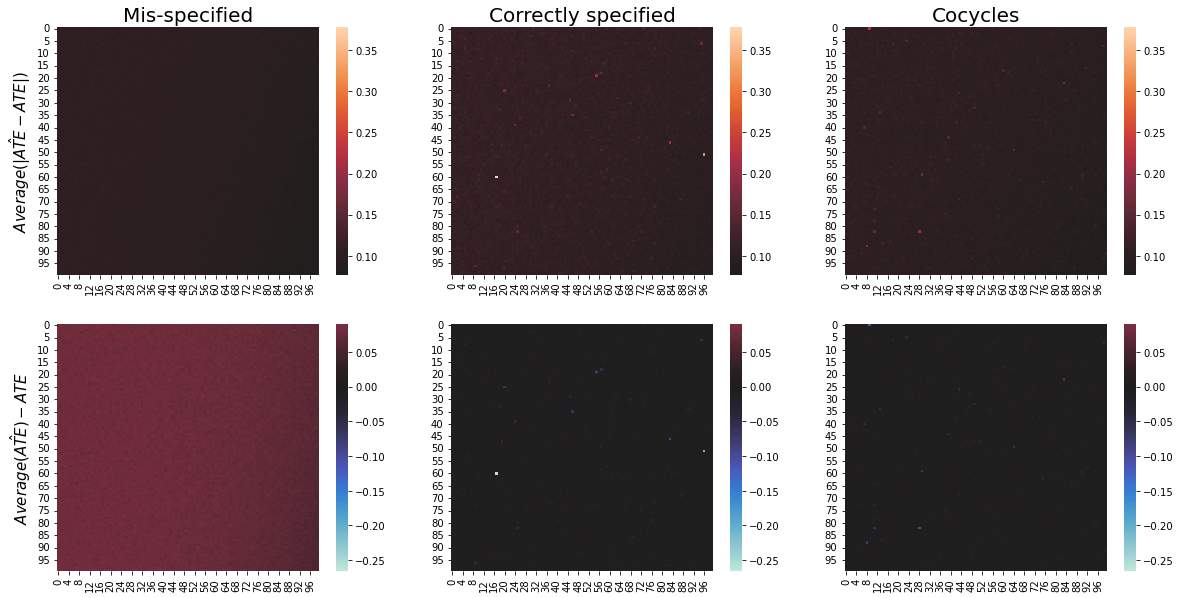

In [8]:
fig,axs = plt.subplots(2,3,figsize = (20,10))
t=0

# Getting max and mins
min_1 = min(np.min((np.abs(EZ_ols_trim[0]- EZ_ols_trim[3])**1).mean(0)),
            np.min((np.abs(EZ_ols_trim[1]- EZ_ols_trim[3])**1).mean(0)),
            np.min((np.abs(EZ_ols_trim[2]- EZ_ols_trim[3])**1).mean(0)))
max_1 = max(np.max((np.abs(EZ_ols_trim[0]- EZ_ols_trim[3])**1).mean(0)),
            np.max((np.abs(EZ_ols_trim[1]- EZ_ols_trim[3])**1).mean(0)),
            np.max((np.abs(EZ_ols_trim[2]- EZ_ols_trim[3])**1).mean(0)))
min_2 = min(np.min(EZ_ols_trim.mean(1)[0]- EZ_ols_trim.mean(1)[3]),
            np.min(EZ_ols_trim.mean(1)[1]- EZ_ols_trim.mean(1)[3]),
            np.min(EZ_ols_trim.mean(1)[2]- EZ_ols_trim.mean(1)[3]))
max_2 = max(np.max(EZ_ols_trim.mean(1)[0]- EZ_ols_trim.mean(1)[3]),
            np.max(EZ_ols_trim.mean(1)[1]- EZ_ols_trim.mean(1)[3]),
            np.max(EZ_ols_trim.mean(1)[2]- EZ_ols_trim.mean(1)[3]))


Row_labels = ["Mis-specified", "Correctly specified", "Cocycles"]
for i in [0,1,2]:
    s = sns.heatmap((np.abs(EZ_ols_trim[i]- EZ_ols_trim[3])**1).mean(0), center = min_1,vmin = min_1,vmax = max_1, ax = axs[0,t])#, cmap = "RdBu_r")
    sns.heatmap(EZ_ols_trim.mean(1)[i]- EZ_ols_trim.mean(1)[3], center = 0,vmin = min_2,vmax = max_2, ax = axs[1,t])#, cmap = "RdBu_r")
    t+=1
axs[0,0].set_ylabel(r"$Average(|{\hat{ATE}} - ATE|)$", fontsize = 15)
axs[0,0].set_title(Row_labels[0], fontsize = 20)
axs[1,0].set_ylabel(r"$Average({\hat{ATE}}) - ATE$", fontsize = 15)
axs[0,1].set_title(Row_labels[1], fontsize = 20)
axs[0,2].set_title(Row_labels[2], fontsize = 20)
fig.savefig("heatmap_misspec_example_trim=01pc",bbox_inches = "tight")

In [9]:
Table = np.zeros((1,4)).astype(str)
i,j = 99,81
Table[0] = (EZ_ols.mean(1)[0,i,j].astype(str) + " ± " + (EZ_ols.var(1)[0,i,j]**0.5).astype(str),
            EZ_ols.mean(1)[1,i,j].astype(str) + " ± " + (EZ_ols.var(1)[1,i,j]**0.5).astype(str),
            EZ_ols.mean(1)[2,i,j].astype(str) + " ± " + (EZ_ols.var(1)[2,i,j]**0.5).astype(str),
            EZ_ols.mean(1)[3,i,j].astype(str) )
print("x_0 = ",X_hard[i],"scale_y = ", Y_scale[j])
print(tabulate(Table, ("Sampling + Mis-specified","Sampling","Cocycles","Ground truth"), tablefmt="latex"))

Table = np.zeros((1,4)).astype(str)
Table[0] = ((np.abs(EZ_ols[0,:,i,j]-EZ_ols[3,:,i,j])).mean().astype(str) + " ± " + ((np.abs(EZ_ols[0,:,i,j]-EZ_ols[3,:,i,j])).var()**0.5).astype(str),
            (np.abs(EZ_ols[1,:,i,j]-EZ_ols[3,:,i,j])).mean().astype(str) + " ± " + ((np.abs(EZ_ols[1,:,i,j]-EZ_ols[3,:,i,j])**2).var()**0.5).astype(str),
            (np.abs(EZ_ols[2,:,i,j]-EZ_ols[3,:,i,j])).mean().astype(str) + " ± " + ((np.abs(EZ_ols[2,:,i,j]-EZ_ols[3,:,i,j])**2).var()**0.5).astype(str),
            (np.abs(EZ_ols[3,:,i,j]-EZ_ols[3,:,i,j])).mean().astype(str) )
print("x_0 = ",X_hard[i],"scale_y = ", Y_scale[j])
print(tabulate(Table, ("Sampling + Mis-specified","Sampling","Cocycles","Ground truth"), tablefmt="latex"))

x_0 =  1.0 scale_y =  0.6590909090909092
\begin{tabular}{lllr}
\hline
 Sampling + Mis-specified         & Sampling                         & Cocycles                         &   Ground truth \\
\hline
 0.03751960801313613 ± 0.08090157 & -0.02522444550747823 ± 0.1219240 & -0.027596828538317658 ± 0.122100 &     -0.0297571 \\
\hline
\end{tabular}
x_0 =  1.0 scale_y =  0.6590909090909092
\begin{tabular}{lllr}
\hline
 Sampling + Mis-specified         & Sampling                         & Cocycles                         &   Ground truth \\
\hline
 0.08707952688060651 ± 0.05906251 & 0.09161595154441499 ± 0.03878671 & 0.08989731594325326 ± 0.04629251 &              0 \\
\hline
\end{tabular}
